### Preparação do ambiente

Este projeto demanda a instalação dos pacotes **numpy, matplotlib e gym[all]**

### Preâmbulo do projeto

Importação de todos pacotes necessários

In [1]:
import gym, math, tqdm, numpy as np, matplotlib.pyplot as plt

### Inicialização do ambiente e das variáveis

In [2]:
env_name = "MountainCar-v0"
env = gym.make(env_name)
discrete = (10, 100)
num_eps = 3000
epsilon, min_epsilon = 0.0, 0.1
learning_rate, min_learning_rate = 0.0, 0.3
discount_factor = 0.95
dec = 15
# Pode retornar os valores low[] e high[] direto do 'env', mas preferi colocar fixos aqui.
lower = [-1.2, -0.07]
upper = [0.6, 0.07]
qtable = np.zeros(discrete + (env.action_space.n, ))

/home/wasf84/.local/lib/python3.10/site-packages/gym/core.py:329: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/home/wasf84/.local/lib/python3.10/site-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


### Métodos que serão empregados na geração da QTable

In [3]:
def choose_action(state):
    """
        O fator aleatório para melhorar o aprendizado
    """
    if (np.random.random() < epsilon):
        return env.action_space.sample()
    else:
        return np.argmax(qtable[state])
# ---------------------------------------------------------------------#
def discrete_state(state):
    """
        Recebe um espaço de observação (observation space) e o discretiza
    """
    d = list()

    for i in range(len(state)):
        stepsize = (state[i] + abs(lower[i])) / (upper[i] - lower[i])
        new_state = int(round((discrete[i] - 1) * stepsize))
        new_state = min(discrete[i] - 1, max(0, new_state))
        d.append(new_state)

    return tuple(d)
# ---------------------------------------------------------------------#
def get_epsilon(ep):
    # vai reduzindo o epsilon para diminuir a ganância do algoritmo
    # entretando, existe um valor mínimo que não reduz para garantir alguma aleatoriedade
    # reduz à medida que aumenta a quantidade de episódios
    # https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
    return max(min_epsilon, min(1., 1. - math.log10((ep + 1) / dec)))
# ---------------------------------------------------------------------#
def get_learning_rate(ep):
    # vai reduzindo a taxa de aprendizagem para diminuir a ganância do algoritmo
    # entretando, existe um valor mínimo que não reduz para garantir algum aprendizado
    # reduz à medida que aumenta a quantidade de episódios
    # https://web.stanford.edu/class/psych209/Readings/SuttonBartoIPRLBook2ndEd.pdf
    return max(min_learning_rate, min(1., 1. - math.log10((ep + 1) / dec)))
# ---------------------------------------------------------------------#
def update_qtable(state, action, reward, new_state):
    # isso está no Google Colab da disciplina
    qtable[state][action] += learning_rate * (reward + discount_factor * np.max(qtable[new_state]) - qtable[state][action])

### Treinamento

In [4]:
# usado para plotar o gráfico de aprendizado
tr = []

for ep in tqdm.tqdm(range(num_eps)):
    current_state = discrete_state(env.reset())

    learning_rate = get_learning_rate(ep)
    epsilon = get_epsilon(ep)
    done = False
    
    # usado para plotar o gráfico de aprendizado
    r = []

    while not done:
        action = choose_action(current_state)
        observation, reward, done, _ = env.step(action)
        new_state = discrete_state(observation)
        update_qtable(current_state, action, reward, new_state)
        current_state = new_state
        r.append(reward)
        
    env.close()
    tr.append(sum(r))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:33<00:00, 89.52it/s]


### Gráfico da aprendizagem

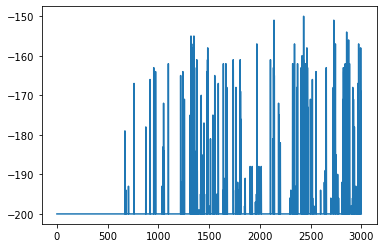

In [5]:
plt.plot(tr)

### Execução

In [6]:
tr = []     # usado para plotar o histograma
i = 0       # macete para renderizar alguns episodios

# executando sempre para 10% de passos sobre o número total de episódios usados para treinamento
for _ in tqdm.tqdm(range(int(num_eps * 0.1))):
    
    # ambiente a ser avaliado
    env_t = gym.make(env_name)
    
    # usado para plotar o gráfico de aprendizado
    r = []

    done = False

    # estado atual
    cs = discrete_state(env_t.reset())

    while not done:
        
        # Renderizar os ultimos 5 episodios
        if i >= (int(num_eps * 0.1) - 5):
            env_t.render()

        action = np.argmax(qtable[cs])
        obs, reward, done, _ = env_t.step(action)
        new_state = discrete_state(obs)
        cs = new_state
        r.append(reward)
        
    i += 1
    env_t.close()
    tr.append(sum(r))

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍      | 290/300 [00:02<00:00, 112.39it/s]/home/wasf84/.local/lib/python3.10/site-packages/gym/core.py:57: DeprecationWarning: WARN: You are calling render method, but you didn't specified the argument render_mode at environment initialization. To maintain backward compatibility, the environment will render in human mode.
If you want to render in human mode, initialize the environment in this way: gym.make('EnvName', render_mode='human') and don't call the render method.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:35<00:00,  8.52it/s]


### Histograma da execução

(array([147.,  32.,  17.,  10.,  19.,  19.,  24.,  17.,   2.,  13.]),
 array([-200. , -195.9, -191.8, -187.7, -183.6, -179.5, -175.4, -171.3,
        -167.2, -163.1, -159. ]),
 <BarContainer object of 10 artists>)

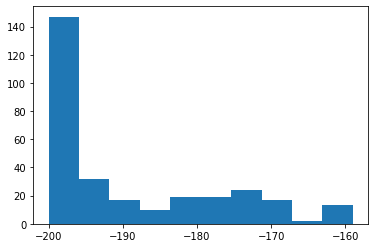

In [7]:
plt.hist(tr)